# Summarise the attribution analysis

In this notebook we generate a number of plots demonstrating the statistical attribution of phenology trends

In [1]:
import os
import sys
import xvec
import pickle
import scipy
import textwrap
import warnings
import distinctipy
import numpy as np
import xarray as xr
import pandas as pd
import seaborn as sb
from scipy import stats
import geopandas as gpd
import contextily as ctx
import matplotlib.pyplot as plt
from odc.geo.xr import assign_crs
import matplotlib.colors as colors
import matplotlib.ticker as ticker
from scipy.stats import gaussian_kde
from scipy.interpolate import griddata
from matplotlib.colors import LinearSegmentedColormap
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

sys.path.append('/g/data/os22/chad_tmp/AusEFlux/src/')
from _prediction import allNaN_arg
from _utils import round_coords
from _feature_datasets import _c4_grass_fraction

%matplotlib inline

/g/data/os22/chad_tmp/AusENDVI/env/py310/lib/python3.10/site-packages/dask/config.py:779: FutureWarning: Dask configuration key 'ucx' has been deprecated; please use 'distributed.comm.ucx' instead
  warnings.warn(
/g/data/os22/chad_tmp/AusENDVI/env/py310/lib/python3.10/site-packages/dask/config.py:779: FutureWarning: Dask configuration key 'distributed.scheduler.transition-log-length' has been deprecated; please use 'distributed.admin.low-level-log-length' instead
  warnings.warn(
/g/data/os22/chad_tmp/AusENDVI/env/py310/lib/python3.10/site-packages/dask/config.py:779: FutureWarning: Dask configuration key 'distributed.comm.recent-messages-log-length' has been deprecated; please use 'distributed.admin.low-level-log-length' instead
  warnings.warn(


## Open data


In [2]:
#phenology data
p_attribution_pls = assign_crs(xr.open_dataset('/g/data/os22/chad_tmp/Aus_phenology/results/attribution_vPOS_PLS_perpixel.nc'), crs='EPSG:4326')
p_attribution_ml = assign_crs(xr.open_dataset('/g/data/os22/chad_tmp/Aus_phenology/results/attribution_vPOS_ML_perpixel.nc'), crs='EPSG:4326')
p_attribution_pcmci = assign_crs(xr.open_dataset('/g/data/os22/chad_tmp/Aus_phenology/results/attribution_vPOS_PCMCI_perpixel.nc'), crs='EPSG:4326')
p_attribution_delta_slope = assign_crs(xr.open_dataset('/g/data/os22/chad_tmp/Aus_phenology/results/attribution_vPOS_delta_slope_perpixel.nc'), crs='EPSG:4326')

# p_parcorr = assign_crs(xr.open_dataset('/g/data/os22/chad_tmp/Aus_phenology/results/parcorr_phenology_perpixel.nc'), crs='EPSG:4326')
p_trends = assign_crs(xr.open_dataset('/g/data/os22/chad_tmp/Aus_phenology/results/trends_phenology_perpixel.nc'), crs='EPSG:4326')

# cropping for masking
crops = xr.open_dataset('/g/data/os22/chad_tmp/Aus_phenology/data/croplands_5km.nc')['croplands']
crops = xr.where(crops==3, 0, 1) #rainfed crops
crops = round_coords(crops)

# some other enviro datasets for plots
trees = xr.open_dataset('/g/data/os22/chad_tmp/AusENDVI/data/5km/trees_5km_monthly_1982_2022.nc')['trees']
trees = trees.mean('time')

vegh = xr.open_dataset('/g/data/os22/chad_tmp/AusENDVI/data/5km/VegH_5km_monthly_1982_2022.nc')['VegH']
vegh = vegh.mean('time')

c4_grass = xr.open_dataset('/g/data/os22/chad_tmp/Aus_phenology/data/C4_grass.nc')['C4_grass']

#moisture index
mi = xr.open_dataarray('/g/data/os22/chad_tmp/Aus_phenology/data/MI_1982_2022.nc')
mi = mi.mean('time')
mi = assign_crs(mi, crs='EPSG:4326')
mi = mi.rename('P:PET')
mi = xr.where(mi>5, np.nan, mi) #remove extreme values

#IBRA subregions data if summarise across the regions (mostly superceeded)
ecoregions_file = '/g/data/os22/chad_tmp/Aus_phenology/data/vectors/IBRAv7_subregions_modified.geojson'
gdf = gpd.read_file(ecoregions_file)

## Mask significance and cropping

In [4]:
p_attribution_pls = p_attribution_pls.where(crops)
p_attribution_ml = p_attribution_ml.where(crops)
p_attribution_pcmci = p_attribution_pcmci.where(crops)
p_attribution_delta_slope = p_attribution_delta_slope.where(crops)

# p_parcorr = p_parcorr.where(crops)
p_trends = p_trends.where(crops)

positive_mask = xr.where(p_trends.vPOS_slope > 0, 1, 0)
sig_mask = xr.where(p_trends.vPOS_p_value<=0.05, 1, 0)
sig_mask = (sig_mask & positive_mask)

vPOS_trends = p_trends.vPOS_slope.where(sig_mask)

p_attribution_pls = p_attribution_pls.where(sig_mask)
p_attribution_ml = p_attribution_ml.where(sig_mask)
p_attribution_pcmci = p_attribution_pcmci.where(sig_mask)
p_attribution_delta_slope = p_attribution_delta_slope.where(sig_mask)

## Summary plots

### Climate atttribution for vPOS trends

In [5]:
clim_most_important_var_pls = allNaN_arg(np.abs(p_attribution_pls.PLS_coefficent), dim='feature',stat='max', idx=False)
clim_most_important_var_ml = allNaN_arg(np.abs(p_attribution_ml.importance), dim='feature',stat='max', idx=False)

clim_most_important_var_pcmci = allNaN_arg(np.abs(p_attribution_pcmci.PCMCI), dim='feature',stat='max', idx=False)
clim_most_important_var_delta_slope = allNaN_arg(np.abs(p_attribution_delta_slope.delta_slope), dim='feature',stat='max', idx=False)

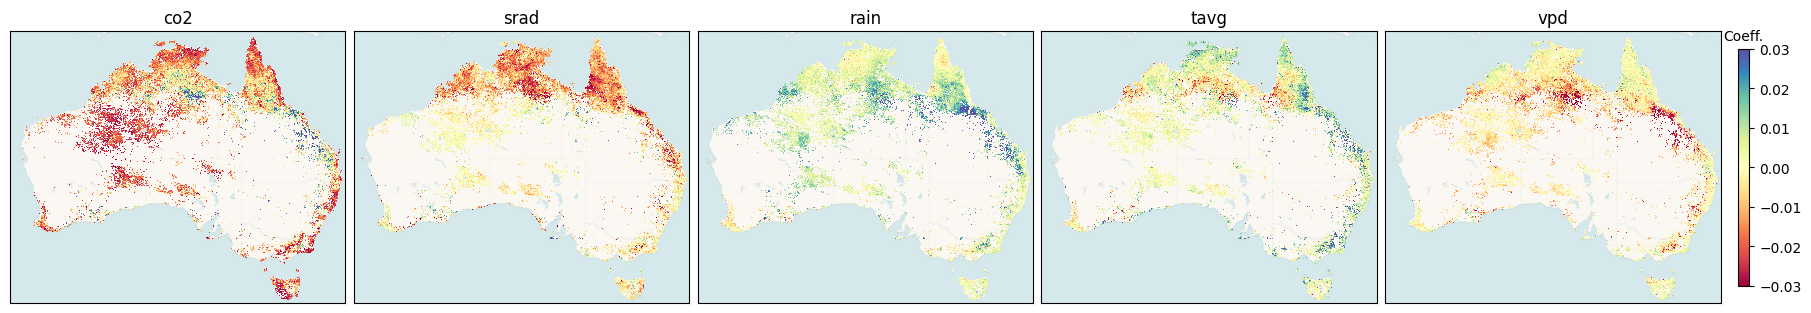

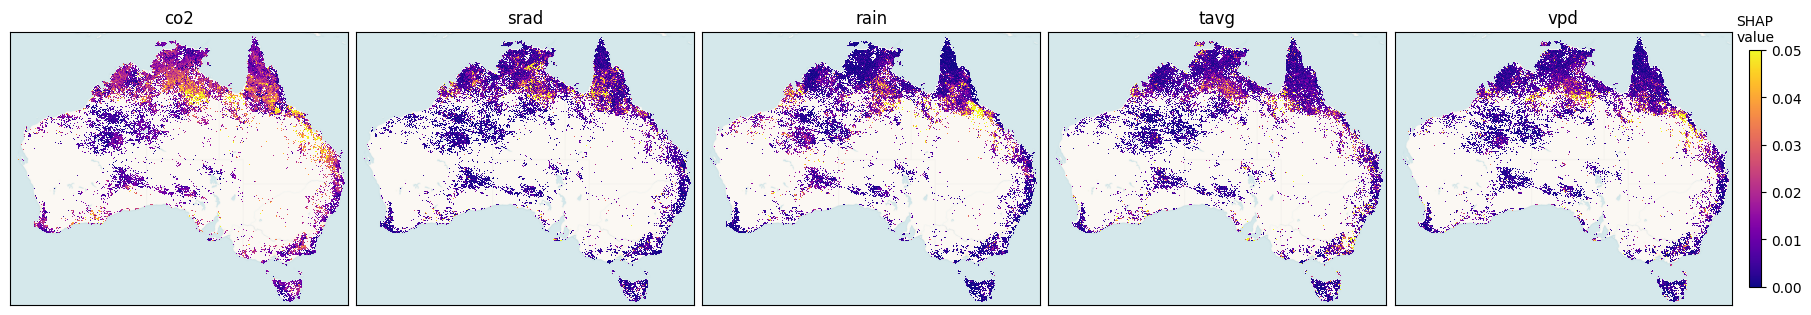

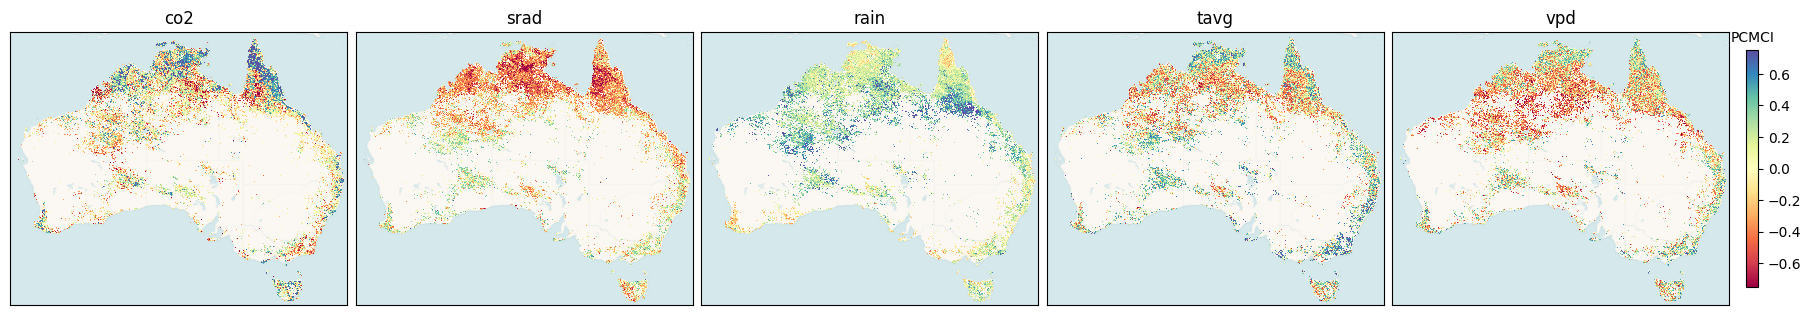

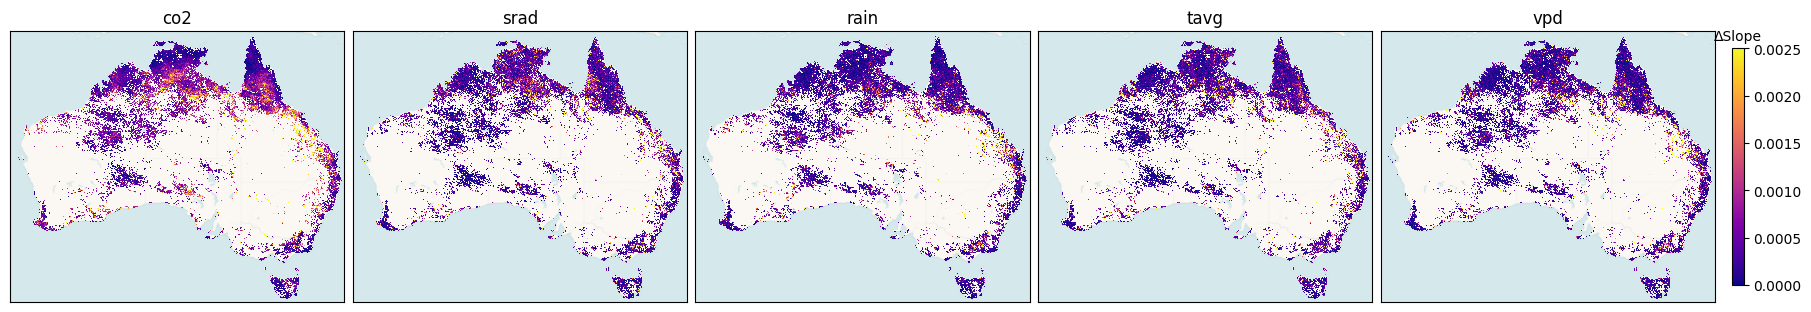

In [6]:
dss = [p_attribution_pls, p_attribution_ml, p_attribution_pcmci, p_attribution_delta_slope]
variables = ['PLS_coefficent', 'importance', 'PCMCI', 'delta_slope']
cmaps = ['Spectral', 'plasma', 'Spectral', 'plasma']
units = ['Coeff.', 'SHAP\nvalue', 'PCMCI', u'ΔSlope']
vmins = [-0.03, 0.0, -0.75, 0.0]
vmaxs = [0.03, 0.05, 0.75, 0.0025]

for ds,vars,cmap,u,vmin,vmax, in zip(dss,variables,cmaps,units,vmins,vmaxs):
    fig,axes=plt.subplots(1,5,figsize=(18,6), layout='constrained')
    d = ds[vars]
    for v,ax in zip(d.feature.values, axes.ravel()):
        d.sel(feature=v).plot(add_labels=False,ax=ax,robust=True, cmap=cmap, add_colorbar=False)
        ctx.add_basemap(ax, source=ctx.providers.CartoDB.VoyagerNoLabels, crs='EPSG:4326', attribution='', attribution_size=1)
        ax.axes.get_xaxis().set_ticks([])
        ax.axes.get_yaxis().set_ticks([])
        ax.set_title(v)
    
    norm = colors.Normalize(vmin=vmin, vmax=vmax)
    cbar = plt.cm.ScalarMappable(norm=norm, cmap=cmap)
    ax_cbar = fig.colorbar(cbar, ax=ax, shrink=0.4)
    ax_cbar.ax.set_title(u, fontsize=10);

#### Plot

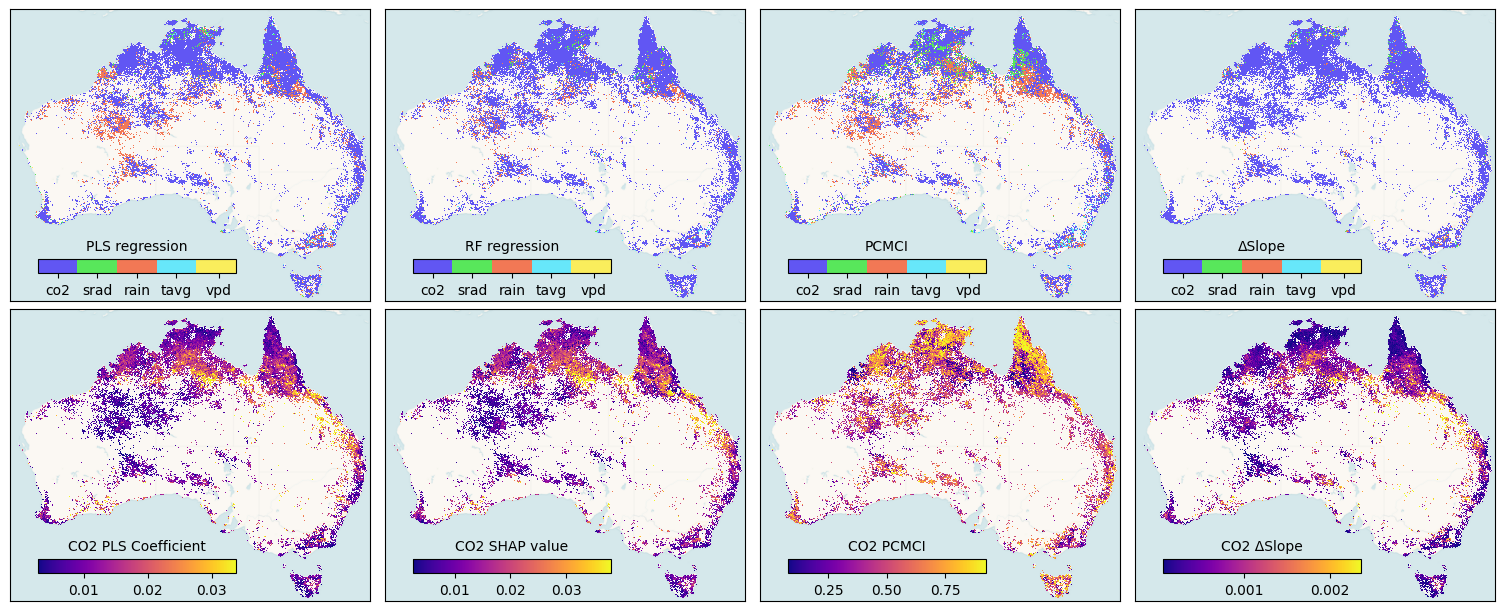

In [7]:
categories = list(p_attribution_pls.feature.values)
colours = distinctipy.get_colors(len(categories), pastel_factor=0.5, rng=2)
cmap = LinearSegmentedColormap.from_list("cwc", colours, N=len(categories))

dss = [
    clim_most_important_var_pls, clim_most_important_var_ml, clim_most_important_var_pcmci, clim_most_important_var_delta_slope,
    p_attribution_pls, p_attribution_ml, p_attribution_pcmci, p_attribution_delta_slope
]

names = ['PLS regression', 'RF regression', 'PCMCI', u'ΔSlope',
        'PLS regression', 'RF regression', 'PCMCI', u'ΔSlope']

variables = [
    'PLS_coefficent', 'importance', 'PCMCI', 'delta_slope',
    'PLS_coefficent', 'importance', 'PCMCI', 'delta_slope'
]
cmaps = ['plasma', 'plasma', 'plasma', 'plasma',
         'plasma', 'plasma', 'plasma', 'plasma']

units = ['PLS Coefficient', 'SHAP value', 'PCMCI', u'ΔSlope',
         'PLS Coefficient', 'SHAP value', 'PCMCI', u'ΔSlope']


fig,axes=plt.subplots(2,4,figsize=(15,6),layout='constrained', sharey=True, sharex=True)

for ds,n,vars,c,u,ax,i in zip(dss,names,variables,cmaps,units,axes.ravel(),range(len(dss))):
    if i <= 3:
        im = ds.plot(add_colorbar=False,ax=ax, add_labels=False, cmap=cmap)
        ctx.add_basemap(ax, source=ctx.providers.CartoDB.VoyagerNoLabels, crs='EPSG:4326', attribution='', attribution_size=1)
        ax.axes.get_xaxis().set_ticks([])
        ax.axes.get_yaxis().set_ticks([])
        axins1 = inset_axes(ax,width="55%",height="5%",loc="lower left", borderpad=2)
        cbar = fig.colorbar(im, cax=axins1, ticks=[0.4,1.2,2,2.8, 3.65],orientation='horizontal')
        cbar.ax.set_xticklabels(categories)
        cbar.ax.set_title(n, fontsize=10)
    if i > 3:
        im2 = ds[vars].sel(feature='co2').plot(ax=ax,add_labels=False,robust=True, cmap=c, add_colorbar=False)
        ctx.add_basemap(ax, source=ctx.providers.CartoDB.VoyagerNoLabels, crs='EPSG:4326', attribution='', attribution_size=1)
        axins2 = inset_axes(ax,width="55%",height="5%",loc="lower left", borderpad=2)
        cbar2 = fig.colorbar(im2, cax=axins2, orientation='horizontal')
        cbar2.ax.set_title('CO2 '+u, fontsize=10)
        ax.axes.get_xaxis().set_ticks([])
        ax.axes.get_yaxis().set_ticks([]);

fig.savefig(f'/g/data/os22/chad_tmp/Aus_phenology/results/figs/attribution_vPOS_AusENDVI.png',
            bbox_inches='tight', dpi=300)

## Agreement between modelled slope and actual slope

In [8]:
slope_difference = p_attribution_pls.slope_actual.sel(feature='co2') -  p_attribution_pls.slope_modelled.sel(feature='co2')
slope_difference.name = 'Slope difference (observed-modelled)'
slope_difference = slope_difference.to_dataset()

ds_slopes = [p_attribution_pls.sel(feature='co2'), p_attribution_pls.sel(feature='co2'), slope_difference]
variables = ['slope_actual', 'slope_modelled', 'Slope difference (observed-modelled)']
names = ['vPOS obs. yr\u207B\u00B9', 'vPOS modelled (PLS) yr\u207B\u00B9', 'Difference (observed-modelled)']

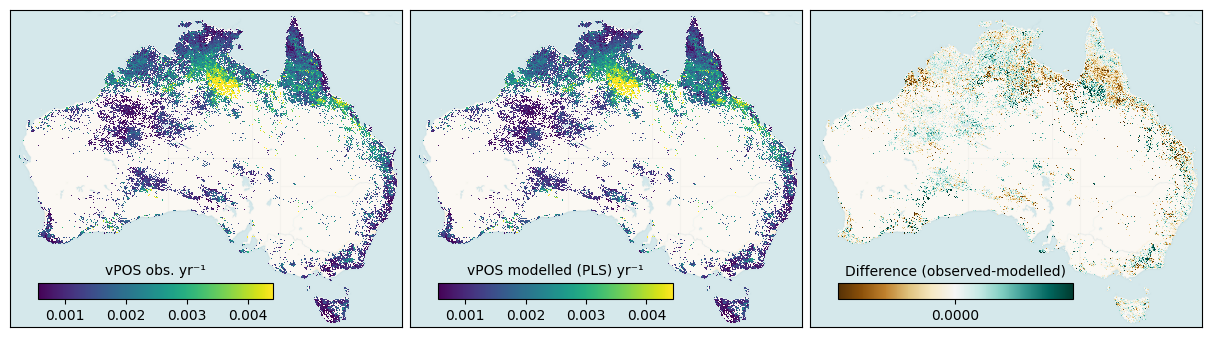

In [9]:
fig,axes=plt.subplots(1,3,figsize=(12,4),layout='constrained', sharey=True, sharex=True)

for ds,n,vars,ax in zip(ds_slopes, names, variables, axes.ravel()):
    if n=='Difference (observed-modelled)':
        cmap = 'BrBG'
    else:
        cmap='viridis'
    im = ds[vars].plot(ax=ax, add_labels=False, robust=True, cmap=cmap, add_colorbar=False)
    ax.axes.get_xaxis().set_ticks([])
    ax.axes.get_yaxis().set_ticks([])
    ctx.add_basemap(ax, source=ctx.providers.CartoDB.VoyagerNoLabels, crs='EPSG:4326', attribution='', attribution_size=1)
    # ax.set_title(n)
    axins1 = inset_axes(ax, width="60%",height="5%",loc="lower left", borderpad=2)
    if n=='Difference (observed-modelled)':
        cbar = fig.colorbar(im, cax=axins1, ticks=[-0.0005, 0.0, 0.0005], orientation='horizontal')
    else:
        cbar = fig.colorbar(im, cax=axins1,orientation='horizontal')
    cbar.ax.set_title(n, fontsize=10)

fig.savefig(f'/g/data/os22/chad_tmp/Aus_phenology/results/figs/modelled_vs_actual_slope_vPOS_AusENDVI.png',
            bbox_inches='tight', dpi=300)

## Relationship between environmental gradients and CO2 sensitivity

### CO2 sensitivity

In [10]:
dss = [p_attribution_pls, p_attribution_ml, p_attribution_pcmci, p_attribution_delta_slope]
variables = ['PLS_coefficent', 'importance', 'PCMCI', 'delta_slope']
names = ['PLS regression', 'RF regression', 'PCMCI', 'ΔSlope']

co2_dffs = {}
for ds,v,n in zip(dss,variables,names):
    co2 = ds[v].sel(feature='co2').where(ds[v].sel(feature='co2')>0).drop_vars('feature')
    co2_df = co2.to_dataframe().reset_index(drop=True).drop(['spatial_ref'],axis=1)
    
    co2_df['P:PET'] = mi.where(~np.isnan(co2)).to_dataframe().reset_index(drop=True).drop(['spatial_ref'],axis=1)
    co2_df['Trees'] = trees.where(~np.isnan(co2)).to_dataframe().reset_index(drop=True).drop(['spatial_ref'],axis=1)
    # co2_df['VegH'] = vegh.where(~np.isnan(co2)).to_dataframe().reset_index(drop=True).drop(['spatial_ref'],axis=1)
    co2_df['C4Grass'] = c4_grass.where(~np.isnan(co2)).to_dataframe().reset_index(drop=True).drop(['spatial_ref'],axis=1)
    co2_df = co2_df.dropna()
    co2_dffs[n] = co2_df

#### Scatter plots

In [ ]:
vars = ['P:PET', 'Trees', 'C4Grass']
for (k,v),var in zip(co2_dffs.items(), variables):

    fig,axes=plt.subplots(1,3, figsize=(9,3),  layout='constrained', sharey=True)

    df = co2_dffs[k]
    
    for v,ax in zip(vars, axes.ravel()): 
        obs,pred = df[v].values, df[var].values
        mask = ~np.isnan(obs) & ~np.isnan(pred)
        sl, i, r, p, s = stats.linregress(obs[mask],pred[mask])
        r2 = r**2
        
        xy = np.vstack([obs[mask],pred[mask]])
        z = gaussian_kde(xy)(xy)
        
        sb.scatterplot(data=df, x=v,y=var, alpha=0.5, ax=ax, c=z, cmap='magma')
        sb.regplot(data=df, x=v,y=var,  scatter=False,
                   line_kws={'linewidth':1}, color='blue', ax=ax, robust=True)
        # ax.set_ylim(0, 0.08)
        # ax.set_title()
        ax.grid()
        ax.set_ylabel(f'CO2 {k}, vPOS', fontsize=12)
        ax.set_xlabel(v, fontsize=12)
        ax.text(.70, .90, 'r\N{SUPERSCRIPT TWO}={:.2f}'.format(r2),
                transform=ax.transAxes, fontsize=12)
        ax.text(.70, .825, 'p={:.3f}'.format(p), transform=ax.transAxes, fontsize=12);

#### Binned bar plots

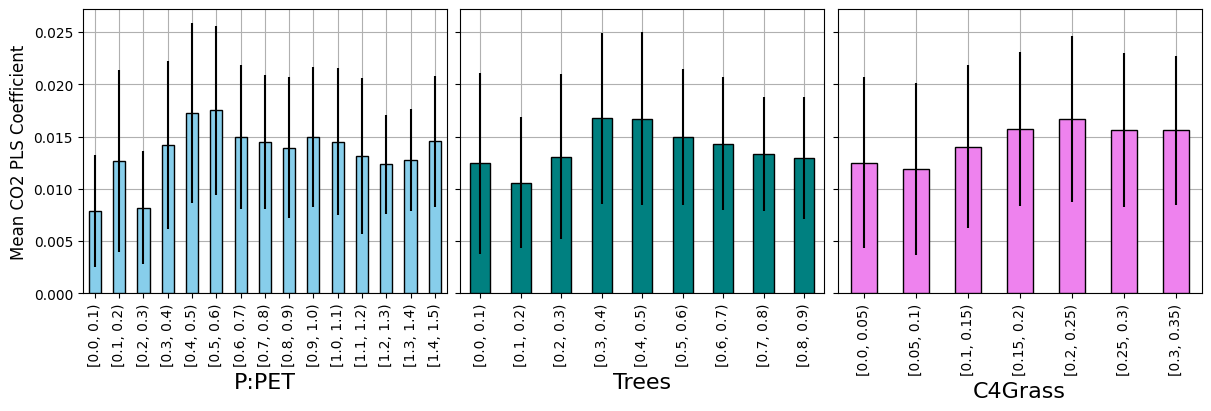

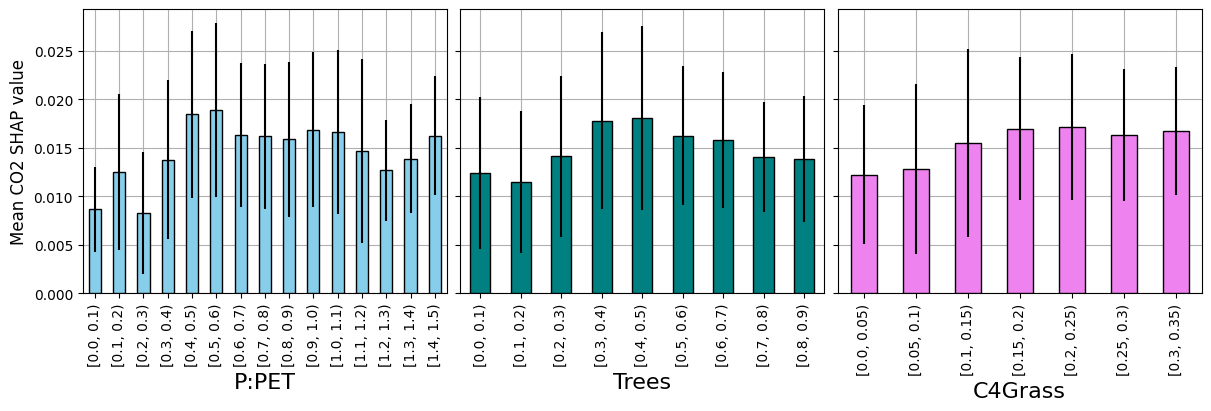

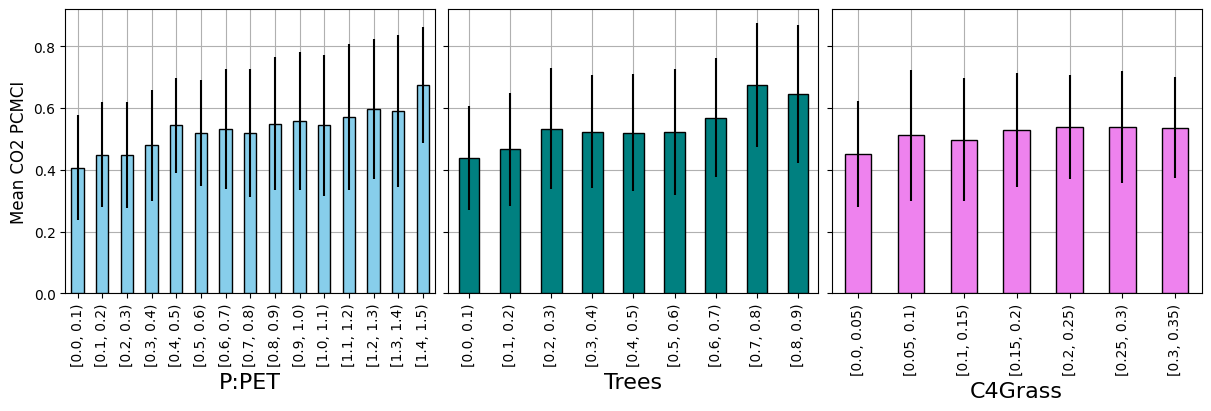

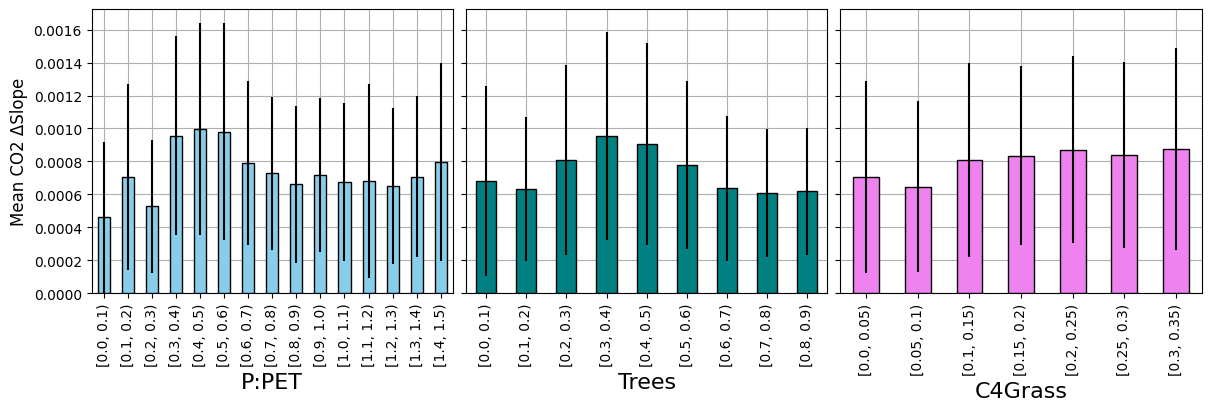

In [11]:
variables = ['PLS_coefficent', 'importance', 'PCMCI', 'delta_slope']
units = ['PLS Coefficient', 'SHAP value', 'PCMCI', u'ΔSlope']
env_vars = ['P:PET', 'Trees', 'C4Grass']
save_names = ['PLS', 'ML', 'PCMCI', 'delta_slope']
cls = ['skyblue', 'teal', 'violet']

for (key,value),var,u,s in zip(co2_dffs.items(), variables, units, save_names):
    bins = [
        np.arange(0,1.6,0.1),
        np.arange(0,1, 0.1),
        np.arange(0,0.4, 0.05)
        ]
    
    df = co2_dffs[key]
    
    fig,axes=plt.subplots(1,3, figsize=(12,4),  layout='constrained', sharey=True)
    
    for ev,b,ax,c in zip(env_vars, bins, axes.ravel(), cls): 
        bins = pd.cut(df[ev], bins=b, right=False)
        grouped = df.groupby(bins, observed=True)[var].mean()
        stddev = df.groupby(bins, observed=True)[var].std()
        grouped.plot(kind='bar', color=c, edgecolor='black', ax=ax, zorder=10, yerr=stddev)
        ax.set_xlabel(ev, fontsize=16)
        ax.grid()
        ax.set_ylabel(f'Mean CO2 {u}', fontsize=12);
        
    fig.savefig(f'/g/data/os22/chad_tmp/Aus_phenology/results/figs/CO2_sensitivity_vPOS_binned_{s}_AusENDVI.png',
                    bbox_inches='tight', dpi=300)

### CO2 sensitivity but disaggregated by simple veg groups

In [12]:
veg = xr.open_dataarray('/g/data/os22/chad_tmp/Aus_phenology/data/NVISv6_simplified_5km.nc')

In [13]:
nvis_simple_names = {
    1:'Forests',
    2:'Shrubs',
    3:'Grasses',
    4:'Non-native\n(rainfed crop)',
    5:'Other'
}

env_dss = {'P:PET':mi, 'trees':trees, 'C4Grass':c4_grass}

def extract_vars(ds, feature, statistic, env_dss, classes_to_extract, nvis, nvis_dict):
    dfs = []
    for c in classes_to_extract: #loop through veg classes
        xx = ds[statistic].sel(feature=feature).where(ds[statistic].sel(feature='co2')>0).drop_vars('feature').where(veg==c)
        xx_df = xx.to_dataframe().reset_index(drop=True).drop(['spatial_ref'],axis=1)
        
        for env_var,env_ds in env_dss.items():
            xx_df[env_var] = env_ds.where(~np.isnan(xx)).to_dataframe().reset_index(drop=True).drop(['spatial_ref'],axis=1)
            xx_df['veg_type'] = nvis_simple_names[c]
        
        xx_df = xx_df.dropna()
        dfs.append(xx_df)

    return pd.concat(dfs).set_index('veg_type')

pls_co2 = extract_vars(p_attribution_pls,'co2', 'PLS_coefficent', env_dss, [1,2,3], veg, nvis_simple_names)
ml_co2 = extract_vars(p_attribution_ml,'co2', 'importance', env_dss, [1,2,3], veg, nvis_simple_names)
pcmci_co2 = extract_vars(p_attribution_pcmci,'co2', 'PCMCI', env_dss, [1,2,3], veg, nvis_simple_names)
delta_slope_co2 = extract_vars(p_attribution_delta_slope,'co2', 'delta_slope', env_dss, [1,2,3], veg, nvis_simple_names)

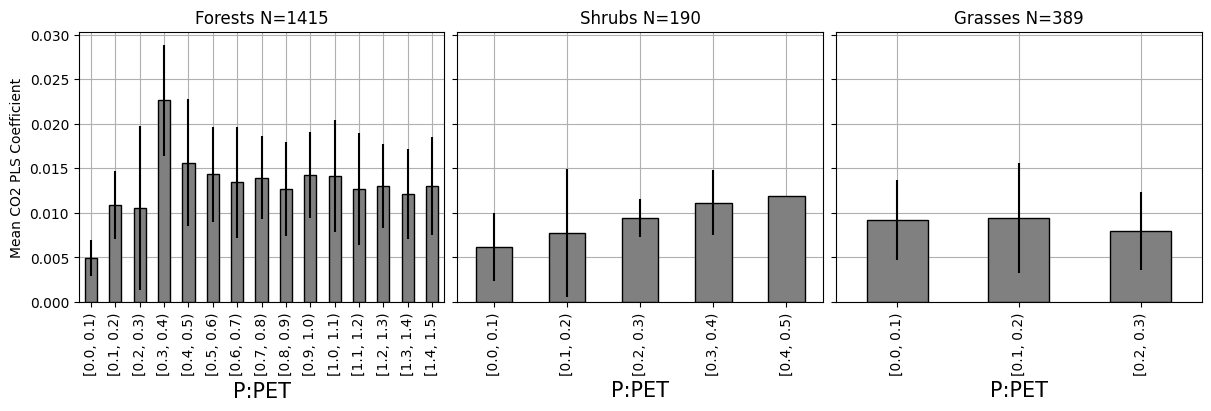

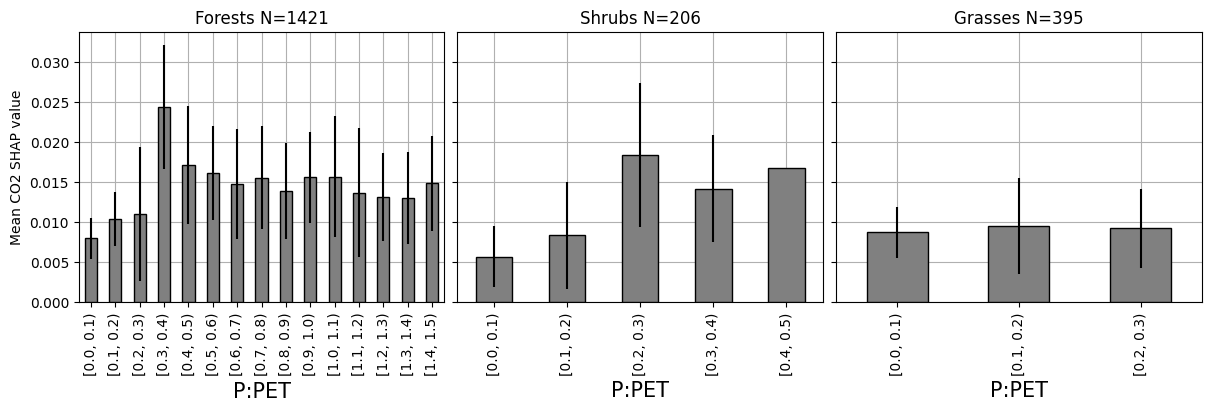

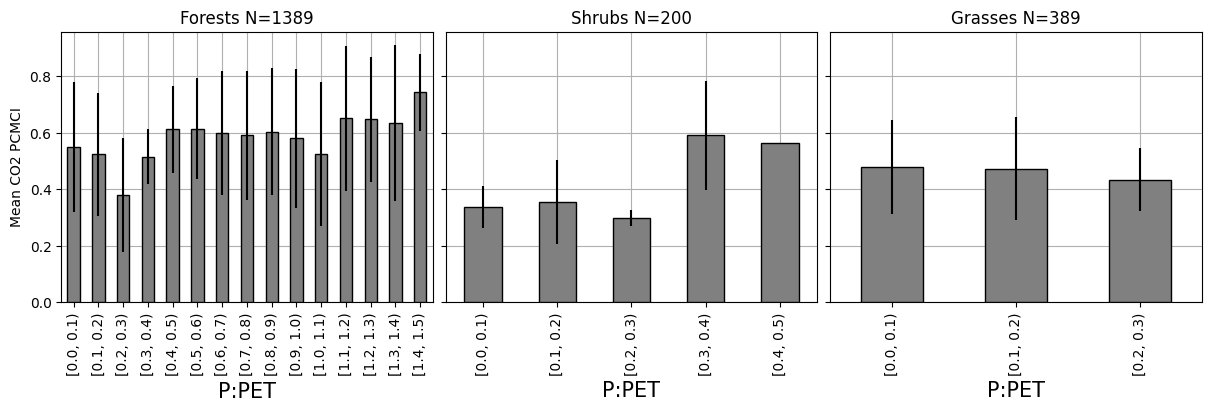

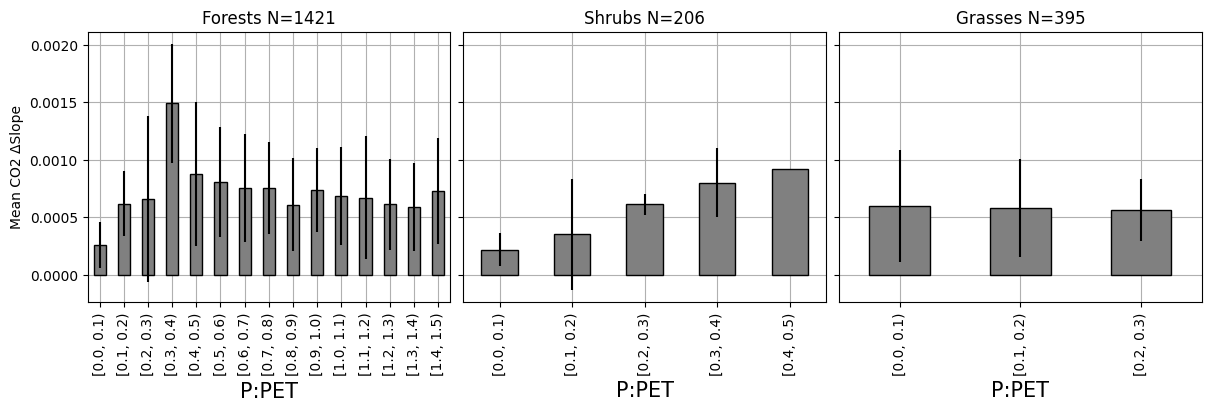

In [14]:
dss = [pls_co2, ml_co2, pcmci_co2, delta_slope_co2]
variables = ['PLS_coefficent', 'importance', 'PCMCI', 'delta_slope']
units = ['PLS Coefficient', 'SHAP value', 'PCMCI', u'ΔSlope']

for ds,var,u in zip(dss,variables,units):
    
    fig,axes=plt.subplots(1,3, figsize=(12,4),  layout='constrained', sharey=True)
    
    for v,ax in zip(['Forests', 'Shrubs','Grasses'], axes.ravel()):
        df = ds.loc[v]
        bins = pd.cut(df['P:PET'], bins=np.arange(0,1.6,0.1), right=False)
        grouped = df.groupby(bins, observed=True)[var].mean()
        stddev = df.groupby(bins, observed=True)[var].std()
    
        
        grouped.plot(kind='bar', color='grey', edgecolor='black', ax=ax, zorder=10, yerr=stddev)
        n=len(df['P:PET'])
        ax.set_title(f'{v} N={n}')
        ax.set_xlabel('P:PET', fontsize=15)
        ax.grid()
        ax.set_ylabel(f'Mean CO2 {u}', fontsize=10);
        
    fig.savefig(f'/g/data/os22/chad_tmp/Aus_phenology/results/figs/CO2_sensitivity_vPOS_binned_vegGroups_{var}_AusENDVI.png',
                    bbox_inches='tight', dpi=300)

### VPD Sensitivity

In [ ]:
dss = [p_attribution_pls, p_attribution_ml, p_attribution_pcmci, p_attribution_delta_slope]
variables = ['PLS_coefficent', 'importance', 'PCMCI', 'delta_slope']
names = ['PLS regression', 'RF regression', 'PCMCI', 'ΔSlope']

vpd_dffs = {}
for ds,v,n in zip(dss,variables,names):
    vpd = ds[v].sel(feature='vpd').drop_vars('feature')
    vpd_df = vpd.to_dataframe().reset_index(drop=True).drop(['spatial_ref'],axis=1)
    
    vpd_df['P:PET'] = mi.where(~np.isnan(vpd)).to_dataframe().reset_index(drop=True).drop(['spatial_ref'],axis=1)
    vpd_df['Trees'] = trees.where(~np.isnan(vpd)).to_dataframe().reset_index(drop=True).drop(['spatial_ref'],axis=1)
    vpd_df['VegH'] = vegh.where(~np.isnan(vpd)).to_dataframe().reset_index(drop=True).drop(['spatial_ref'],axis=1)
    vpd_df = vpd_df.dropna()
    vpd_dffs[n] = vpd_df

#### Scatter plots

In [ ]:
vars = ['P:PET', 'Trees', 'VegH']
for (k,v),var in zip(vpd_dffs.items(), variables):

    fig,axes=plt.subplots(1,3, figsize=(9,3),  layout='constrained', sharey=True)

    df = vpd_dffs[k]
    
    for v,ax in zip(vars, axes.ravel()): 
        obs,pred = df[v].values, df[var].values
        mask = ~np.isnan(obs) & ~np.isnan(pred)
        sl, i, r, p, s = stats.linregress(obs[mask],pred[mask])
        r2 = r**2
        
        xy = np.vstack([obs[mask],pred[mask]])
        z = gaussian_kde(xy)(xy)
        
        sb.scatterplot(data=df, x=v,y=var, alpha=0.5, ax=ax, c=z, cmap='magma')
        sb.regplot(data=df, x=v,y=var,  scatter=False,
                   line_kws={'linewidth':1}, color='blue', ax=ax, robust=True)
        # ax.set_ylim(0, 0.08)
        # ax.set_title()
        ax.grid()
        ax.set_ylabel(f'VPD {k}, vPOS', fontsize=12)
        ax.set_xlabel(v, fontsize=12)
        ax.text(.70, .90, 'r\N{SUPERSCRIPT TWO}={:.2f}'.format(r2),
                transform=ax.transAxes, fontsize=12)
        ax.text(.70, .825, 'p={:.3f}'.format(p), transform=ax.transAxes, fontsize=12);

#### Binned bar plots

In [ ]:
variables = ['PLS_coefficent', 'importance', 'PCMCI', 'delta_slope']
units = ['PLS Coefficient', 'SHAP value', 'PCMCI', u'ΔSlope']
env_vars = ['P:PET', 'Trees', 'VegH']
save_names = ['PLS', 'ML', 'PCMCI', 'delta_slope']
cls = ['skyblue', 'teal', 'violet']

for (key,value),var,u,s in zip(vpd_dffs.items(), variables, units, save_names):
    bins = [
        np.arange(0,3.3,0.3),
        np.arange(0,1, 0.1),
        np.arange(0,33, 3)
        ]
    
    df = vpd_dffs[key]
    
    fig,axes=plt.subplots(1,3, figsize=(12,4),  layout='constrained', sharey=True)
    
    for ev,b,ax,c in zip(env_vars, bins, axes.ravel(), cls): 
        bins = pd.cut(df[ev], bins=b, right=False)
        grouped = df.groupby(bins, observed=True)[var].mean()
        stddev = df.groupby(bins, observed=True)[var].std()
        grouped.plot(kind='bar', color=c, edgecolor='black', ax=ax, zorder=10, yerr=stddev)
        ax.set_xlabel(ev)
        ax.grid()
        ax.set_ylabel(f'Mean VPD {u}', fontsize=10);
        
    fig.savefig(f'/g/data/os22/chad_tmp/Aus_phenology/results/figs/VPD_sensitivity_vPOS_binned_{s}_AusENDVI.png',
                    bbox_inches='tight', dpi=300)

### vPOS trends across same gradients

In [ ]:
vPOS_df = vPOS_trends.to_dataframe().reset_index(drop=True).drop(['spatial_ref'],axis=1)

vPOS_df['P:PET'] = mi.where(~np.isnan(vPOS_trends)).to_dataframe().reset_index(drop=True).drop(['spatial_ref'],axis=1)
vPOS_df['Trees'] = trees.where(~np.isnan(vPOS_trends)).to_dataframe().reset_index(drop=True).drop(['spatial_ref'],axis=1)
vPOS_df['VegH'] = vegh.where(~np.isnan(vPOS_trends)).to_dataframe().reset_index(drop=True).drop(['spatial_ref'],axis=1)

vPOS_df = vPOS_df.dropna()

In [ ]:
vars = ['P:PET', 'Trees', 'VegH']
fig,axes=plt.subplots(1,3, figsize=(12,4),  layout='constrained', sharey=True)

for v,ax in zip(vars, axes.ravel()): 
    obs,pred = vPOS_df[v].values, vPOS_df['vPOS_slope'].values
    mask = ~np.isnan(obs) & ~np.isnan(pred)
    sl, i, r, p, s = stats.linregress(obs[mask],pred[mask])
    r2 = r**2
    
    xy = np.vstack([obs[mask],pred[mask]])
    z = gaussian_kde(xy)(xy)
    
    sb.scatterplot(data=vPOS_df, x=v,y='vPOS_slope', alpha=0.5, ax=ax, c=z, cmap='magma')
    sb.regplot(data=vPOS_df, x=v,y='vPOS_slope',  scatter=False,
               line_kws={'linewidth':1}, color='blue', ax=ax, robust=True)
    # ax.set_ylim(0, 0.08)
    # ax.set_title()
    ax.grid()
    ax.set_ylabel('vPOS slope (NDVI/year)', fontsize=14)
    ax.set_xlabel(v, fontsize=14)
    # ax.axhline(0, color='grey', linestyle='--')
    ax.text(.70, .90, 'r\N{SUPERSCRIPT TWO}={:.2f}'.format(r2),
            transform=ax.transAxes, fontsize=12)
    ax.text(.70, .825, 'p={:.3f}'.format(p), transform=ax.transAxes, fontsize=12);
fig.savefig(f'/g/data/os22/chad_tmp/Aus_phenology/results/figs/vPOS_slope_enviro_gradients_AusENDVI.png',
            bbox_inches='tight', dpi=300)

### Same relationships but binning covariables

In [ ]:
vars = ['P:PET', 'Trees', 'VegH']
bins = [
    np.arange(0,3.3,0.3),
    np.arange(0,1, 0.1),
    np.arange(0,33, 3)
]
cls = ['skyblue', 'teal', 'violet']
fig,axes=plt.subplots(1,3, figsize=(12,4),  layout='constrained', sharey=True)

for v,b,ax,c in zip(vars,bins, axes.ravel(), cls): 
    bins = pd.cut(co2_pls_df[v], bins=b, right=False)
    grouped = co2_pls_df.groupby(bins, observed=True)['PLS_coefficent'].mean()
    stddev = co2_pls_df.groupby(bins, observed=True)['PLS_coefficent'].std()
    grouped.plot(kind='bar', color=c, edgecolor='black', ax=ax, zorder=10, yerr=stddev)
    ax.set_xlabel(v)
    ax.grid()
    ax.set_ylabel('Mean CO2 PLS coefficient');
fig.savefig(f'/g/data/os22/chad_tmp/Aus_phenology/results/figs/CO2_sensitivity_vPOS_PLS_bins_AusENDVI.png',
            bbox_inches='tight', dpi=300)

In [ ]:
vars = ['P:PET', 'Trees', 'VegH']
bins = [
    np.arange(0,3.3,0.3),
    np.arange(0,1, 0.1),
    np.arange(0,33, 3)
]
cls = ['skyblue', 'teal', 'violet']
fig,axes=plt.subplots(1,3, figsize=(12,4),  layout='constrained', sharey=True)

for v,b,ax,c in zip(vars,bins, axes.ravel(), cls): 
    bins = pd.cut(co2_ml_df[v], bins=b, right=False)
    grouped = co2_ml_df.groupby(bins, observed=True)['importance'].mean()
    stddev = co2_ml_df.groupby(bins, observed=True)['importance'].std()
    grouped.plot(kind='bar', color=c, edgecolor='black', ax=ax, zorder=10, yerr=stddev)
    ax.set_xlabel(v)
    ax.grid()
    ax.set_ylabel('Mean CO2 SHAP values');
fig.savefig(f'/g/data/os22/chad_tmp/Aus_phenology/results/figs/CO2_sensitivity_vPOS_ML_bins_AusENDVI.png',
            bbox_inches='tight', dpi=300)

In [ ]:
# vPOS_df = p_trends.vPOS_slope.to_dataframe().reset_index(drop=True).drop(['spatial_ref'],axis=1)

# vPOS_df['P:PET'] = mi.where(~np.isnan(p_trends.vPOS_slope)).to_dataframe().reset_index(drop=True).drop(['spatial_ref'],axis=1)
# vPOS_df['WCF'] = wcf.where(~np.isnan(p_trends.vPOS_slope)).to_dataframe().reset_index(drop=True).drop(['spatial_ref'],axis=1)
# vPOS_df['VegH'] = vegh.where(~np.isnan(p_trends.vPOS_slope)).to_dataframe().reset_index(drop=True).drop(['spatial_ref'],axis=1)

# vPOS_df = vPOS_df.dropna()

In [ ]:
vars = ['P:PET', 'Trees', 'VegH']
bins = [
    np.arange(0,3.3,0.3),
    np.arange(0,1, 0.1),
    np.arange(0,33, 3)
]
cls = ['skyblue', 'teal', 'violet']
fig,axes=plt.subplots(1,3, figsize=(12,4),  layout='constrained', sharey=True)

for v,b,ax,c in zip(vars,bins, axes.ravel(), cls): 
    bins = pd.cut(vPOS_df[v], bins=b, right=False)
    grouped = vPOS_df.groupby(bins, observed=True)['vPOS_slope'].mean()
    stddev = vPOS_df.groupby(bins, observed=True)['vPOS_slope'].std()
    grouped.plot(kind='bar', color=c, edgecolor='black', ax=ax, zorder=10, yerr=stddev)
    ax.set_xlabel(v)
    ax.grid(zorder=-10)
    ax.set_ylabel('vPOS slope (NDVI/year)');
fig.savefig(f'/g/data/os22/chad_tmp/Aus_phenology/results/figs/vPOS_slope_enviro_gradients_bins_AusENDVI.png',
            bbox_inches='tight', dpi=300)

### VPD Sensitivity

In [ ]:
# PLS--------------------------
vpd_pls = p_attribution_pls.sel(feature='vpd').PLS_coefficent.where(p_attribution_pls.sel(feature='vpd').PLS_coefficent<=0).drop_vars('feature')
vpd_pls_df = vpd_pls.to_dataframe().reset_index(drop=True).drop(['spatial_ref'],axis=1)

vpd_pls_df['P:PET'] = mi.where(~np.isnan(vpd_pls)).to_dataframe().reset_index(drop=True).drop(['spatial_ref'],axis=1)
vpd_pls_df['Trees'] = trees.where(~np.isnan(vpd_pls)).to_dataframe().reset_index(drop=True).drop(['spatial_ref'],axis=1)
vpd_pls_df['VegH'] = vegh.where(~np.isnan(vpd_pls)).to_dataframe().reset_index(drop=True).drop(['spatial_ref'],axis=1)

vpd_pls_df = vpd_pls_df.dropna()

# ML---------------------------
vpd_ml = p_attribution_ml.sel(feature='vpd').importance.drop_vars('feature')
vpd_ml_df = vpd_ml.to_dataframe().reset_index(drop=True).drop(['spatial_ref'],axis=1)

vpd_ml_df['P:PET'] = mi.where(~np.isnan(vpd_ml)).to_dataframe().reset_index(drop=True).drop(['spatial_ref'],axis=1)
vpd_ml_df['Trees'] = trees.where(~np.isnan(vpd_ml)).to_dataframe().reset_index(drop=True).drop(['spatial_ref'],axis=1)
vpd_ml_df['VegH'] = vegh.where(~np.isnan(vpd_ml)).to_dataframe().reset_index(drop=True).drop(['spatial_ref'],axis=1)

vpd_ml_df = vpd_ml_df.dropna()

#### PLS

In [ ]:
vars = ['P:PET', 'Trees', 'VegH']
fig,axes=plt.subplots(1,3, figsize=(12,4),  layout='constrained', sharey=True)

for v,ax in zip(vars, axes.ravel()): 
    obs,pred = vpd_pls_df[v].values, vpd_pls_df['PLS_coefficent'].values
    mask = ~np.isnan(obs) & ~np.isnan(pred)
    sl, i, r, p, s = stats.linregress(obs[mask],pred[mask])
    r2 = r**2
    
    xy = np.vstack([obs[mask],pred[mask]])
    z = gaussian_kde(xy)(xy)
    
    sb.scatterplot(data=vpd_pls_df, x=v,y='PLS_coefficent', alpha=0.5, ax=ax, c=z, cmap='magma')
    sb.regplot(data=vpd_pls_df, x=v,y='PLS_coefficent',  scatter=False,
               line_kws={'linewidth':1}, color='blue', ax=ax, robust=True)
    # ax.set_ylim(0, 0.08)
    # ax.set_title()
    ax.grid()
    ax.set_ylabel('VPD coefficient, vPOS', fontsize=14)
    ax.set_xlabel(v, fontsize=14)
    ax.text(.70, .90, 'r\N{SUPERSCRIPT TWO}={:.2f}'.format(r2),
            transform=ax.transAxes, fontsize=12)
    ax.text(.70, .825, 'p={:.3f}'.format(p), transform=ax.transAxes, fontsize=12);
fig.savefig(f'/g/data/os22/chad_tmp/Aus_phenology/results/figs/VPD_sensitivity_vPOS_PLS_AusENDVI.png',
            bbox_inches='tight', dpi=300)

In [ ]:
vars = ['P:PET', 'Trees', 'VegH']
bins = [
    np.arange(0,3.3,0.3),
    np.arange(0,1, 0.1),
    np.arange(0,33, 3)
]
cls = ['skyblue', 'teal', 'violet']
fig,axes=plt.subplots(1,3, figsize=(12,4),  layout='constrained', sharey=True)

for v,b,ax,c in zip(vars,bins, axes.ravel(), cls): 
    bins = pd.cut(vpd_pls_df[v], bins=b, right=False)
    grouped = vpd_pls_df.groupby(bins, observed=True)['PLS_coefficent'].mean()
    stddev = vpd_pls_df.groupby(bins, observed=True)['PLS_coefficent'].std()
    grouped.plot(kind='bar', color=c, edgecolor='black', ax=ax, zorder=10, yerr=stddev)
    ax.set_xlabel(v)
    ax.grid()
    ax.set_ylabel('Mean VPD PLS coefficient');
fig.savefig(f'/g/data/os22/chad_tmp/Aus_phenology/results/figs/VPD_sensitivity_vPOS_PLS_bins_AusENDVI.png',
            bbox_inches='tight', dpi=300)

#### ML

In [ ]:
vars = ['P:PET', 'Trees', 'VegH']
fig,axes=plt.subplots(1,3, figsize=(12,4),  layout='constrained', sharey=True)

for v,ax in zip(vars, axes.ravel()): 
    obs,pred = vpd_ml_df[v].values, vpd_ml_df['importance'].values
    mask = ~np.isnan(obs) & ~np.isnan(pred)
    sl, i, r, p, s = stats.linregress(obs[mask],pred[mask])
    r2 = r**2
    
    xy = np.vstack([obs[mask],pred[mask]])
    z = gaussian_kde(xy)(xy)
    
    sb.scatterplot(data=vpd_ml_df, x=v,y='importance', alpha=0.5, ax=ax, c=z, cmap='magma')
    sb.regplot(data=vpd_ml_df, x=v,y='importance',  scatter=False,
               line_kws={'linewidth':1}, color='blue', ax=ax, robust=True)
    # ax.set_ylim(0, 0.08)
    # ax.set_title()
    ax.grid()
    ax.set_ylabel('VPD mean SHAP value, vPOS', fontsize=14)
    ax.set_xlabel(v, fontsize=14)
    ax.text(.70, .90, 'r\N{SUPERSCRIPT TWO}={:.2f}'.format(r2),
            transform=ax.transAxes, fontsize=12)
    ax.text(.70, .825, 'p={:.3f}'.format(p), transform=ax.transAxes, fontsize=12);
fig.savefig(f'/g/data/os22/chad_tmp/Aus_phenology/results/figs/VPD_sensitivity_vPOS_ML_AusENDVI.png',
            bbox_inches='tight', dpi=300)

In [ ]:
vars = ['P:PET', 'Trees', 'VegH']
bins = [
    np.arange(0,3.3,0.3),
    np.arange(0,1, 0.1),
    np.arange(0,33, 3)
]
cls = ['skyblue', 'teal', 'violet']
fig,axes=plt.subplots(1,3, figsize=(12,4),  layout='constrained', sharey=True)

for v,b,ax,c in zip(vars,bins, axes.ravel(), cls): 
    bins = pd.cut(vpd_ml_df[v], bins=b, right=False)
    grouped = vpd_ml_df.groupby(bins, observed=True)['importance'].mean()
    stddev = vpd_ml_df.groupby(bins, observed=True)['importance'].std()
    grouped.plot(kind='bar', color=c, edgecolor='black', ax=ax, zorder=10, yerr=stddev)
    ax.set_xlabel(v)
    ax.grid()
    ax.set_ylabel('Mean VPD SHAP values');
fig.savefig(f'/g/data/os22/chad_tmp/Aus_phenology/results/figs/VPD_sensitivity_vPOS_ML_bins_AusENDVI.png',
            bbox_inches='tight', dpi=300)

## Partial correlations with IOS trends

In [ ]:
# categories = list(p_parcorr.data_vars)
# colours = distinctipy.get_colors(len(categories), pastel_factor=0.5, rng=2)
# cmap = LinearSegmentedColormap.from_list("cwc", colours, N=len(categories))

# categories1 = ['values', 'timing']
# colours1 = distinctipy.get_colors(len(categories1), pastel_factor=0.5, rng=2)
# cmap1 = LinearSegmentedColormap.from_list("cwc", colours1, N=len(categories1))

# ios_most_important_var = allNaN_arg(p_parcorr.to_array(), dim='variable',stat='max', idx=False)
# values_or_timing = xr.where(ios_most_important_var.isin([0,1,2]), 1, 2)

In [ ]:
# fig,ax=plt.subplots(1,2,figsize=(12,6), layout='constrained')
# im = ios_most_important_var.plot(ax=ax[0], add_colorbar=False, add_labels=False, cmap=cmap)
# ctx.add_basemap(ax[0], source=ctx.providers.CartoDB.VoyagerNoLabels, crs='EPSG:4326', attribution='', attribution_size=1)
# ax[0].set_yticklabels([])
# ax[0].set_xticklabels([])
# ax[0].set_title('Phenometric with highest partial correlation with IOS trends');

# axins1 = inset_axes(ax[0],width="65%",height="5%",loc="lower left", borderpad=2)
# cbar = fig.colorbar(im,cax=axins1, ticks=[0.45,1.25,2.15,3,3.85,4.75,5.65,6.5],orientation='horizontal')
# cbar.ax.set_xticklabels(list(p_parcorr.data_vars));

# im = values_or_timing.where(~np.isnan(ios_most_important_var)).plot(ax=ax[1], add_colorbar=False, add_labels=False, cmap=cmap1)
# ctx.add_basemap(ax[1], source=ctx.providers.CartoDB.VoyagerNoLabels, crs='EPSG:4326', attribution='', attribution_size=1)
# ax[1].set_yticklabels([])
# ax[1].set_xticklabels([])
# ax[1].set_title('Values or timing');

# axins1 = inset_axes(ax[1],width="45%",height="5%",loc="lower left", borderpad=2)
# cbar = fig.colorbar(im, cax=axins1, ticks=[1.25,1.75],orientation='horizontal')
# cbar.ax.set_xticklabels(['values', 'timing']);

# fig.savefig(f'/g/data/os22/chad_tmp/Aus_phenology/results/figs/parcorr_perpixel_AusENDVI.png',
#             bbox_inches='tight', dpi=300)

In [ ]:
#### Summarise over IBRA regions

# Using the mode statistics
# clim_most_important_var.name='PLS_coefficent_max'
# clim_most_important_var_gdf = clim_most_important_var.drop_vars('spatial_ref').xvec.zonal_stats(
#     gdf.geometry, x_coords="longitude", y_coords="latitude",
#     stats=[
#         ("mode", scipy.stats.mode, {'nan_policy':'omit'}),
#         # ('count', np.unique, {'return_counts':True, 'equal_nan':True})
#           ]
# ).xvec.to_geodataframe()

# clim_most_important_var_gdf = clim_most_important_var_gdf.dropna()
# clim_most_important_var_gdf['mode'] = [i[0] for i in clim_most_important_var_gdf['PLS_coefficent_max']]
# clim_most_important_var_gdf['count'] = [i[1] for i in clim_most_important_var_gdf['PLS_coefficent_max']]
# clim_most_important_var_gdf = clim_most_important_var_gdf[clim_most_important_var_gdf['count'] >75]

In [ ]:
# ios_most_important_var.name='IOS_most_important_var'
# ios_most_important_var_gdf = ios_most_important_var.drop_vars('spatial_ref').xvec.zonal_stats(
#     gdf.geometry, x_coords="longitude", y_coords="latitude", stats=[("mode", scipy.stats.mode, {'nan_policy':'omit'})]
# ).xvec.to_geodataframe()

# ios_most_important_var_gdf = ios_most_important_var_gdf.dropna()
# ios_most_important_var_gdf['IOS_most_important_var'] = [i[0] for i in ios_most_important_var_gdf['IOS_most_important_var']]

# values_or_timing.name='values_or_timing'
# values_or_timing_gdf = values_or_timing.drop_vars('spatial_ref').xvec.zonal_stats(
#     gdf.geometry, x_coords="longitude", y_coords="latitude", stats=[("mode", scipy.stats.mode, {'nan_policy':'omit'})]
# ).xvec.to_geodataframe()

# values_or_timing_gdf = values_or_timing_gdf.dropna()
# values_or_timing_gdf['values_or_timing'] = [i[0] for i in values_or_timing_gdf['values_or_timing']]

In [ ]:
# fig,ax=plt.subplots(1,2,figsize=(12,6), layout='constrained', sharey=True)
# im = ios_most_important_var_gdf.plot(column='IOS_most_important_var', ax=ax[0], legend=False, cmap=cmap)
# ctx.add_basemap(ax[0], source=ctx.providers.CartoDB.VoyagerNoLabels, crs='EPSG:4326', attribution='', attribution_size=1)
# ax[0].set_yticklabels([])
# ax[0].set_xticklabels([])
# ax[0].set_title('Phenometric with highest partial correlation with IOS trends');

# axins1 = inset_axes(ax[0],width="55%",height="5%",loc="lower left", borderpad=2)
# # norm = colors.Normalize()
# cbar = plt.cm.ScalarMappable(cmap=cmap)
# ax_cbar = fig.colorbar(cbar, cmap=cmap, cax=axins1, ticks=[0.09,0.25,0.4,0.6,0.75,0.925], orientation='horizontal')
# ax_cbar.ax.set_xticklabels(list(p_parcorr.data_vars));

# im = values_or_timing_gdf.plot(ax=ax[1],  cmap=cmap1)
# ctx.add_basemap(ax[1], source=ctx.providers.CartoDB.VoyagerNoLabels, crs='EPSG:4326', attribution='', attribution_size=1)
# ax[1].set_yticklabels([])
# ax[1].set_xticklabels([])
# ax[1].set_title('Values or timing');

# axins1 = inset_axes(ax[1],width="55%",height="5%",loc="lower left", borderpad=2)
# # norm = colors.Normalize()
# cbar = plt.cm.ScalarMappable(cmap=cmap1)
# ax_cbar = fig.colorbar(cbar, cmap=cmap1, cax=axins1, ticks=[0.25,0.75], orientation='horizontal')
# ax_cbar.ax.set_xticklabels(['values', 'timing']);